In [1]:
import numpy as np
import math
import msprime
import tsinfer
import logging

from IPython.display import SVG, display

/Users/anthonywohns/anaconda_ete/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def msprime_simulation(name,sample_size, Ne, length, recombination_rate, mutation_rate):
    #Step one: simulate dataset with msprime
    simulation = msprime.simulate(sample_size=sample_size, Ne=Ne, length=length, recombination_rate=recombination_rate, mutation_rate=mutation_rate)
    with open("../tmp/"+name+".vcf", "w") as vcf_file:
        simulation.write_vcf(vcf_file, 2)
    return(simulation)

def make_errors(g, p):
    """
    Resample for a specific variant, whose genotypes g are passed in
    For each sample an error occurs with probability p. Errors are generated by
    sampling values from the stationary distribution, that is, if we have an
    allele frequency of f, a 1 is emitted with probability f and a
    0 with probability 1 - f. Thus, there is a possibility that an 'error'
    will in fact result in the same value.
    """
    w = np.copy(g)
    if p > 0:
        m = g.shape[0]
        frequency = np.sum(g) / m
        # Randomly choose samples with probability p
        samples = np.where(np.random.random(m) < p)[0]
        # Generate observations from the stationary distribution.
        errors = (np.random.random(samples.shape[0]) < frequency).astype(int)
        w[samples] = errors
    return w

def generate_samples(ts, filename, real_error_rate=0):
    """
    Generate a samples file from a simulated ts
    Samples may have bits flipped with a specified probability.
    (reject any variants that result in a fixed column)
    """
    if real_error_rate > 0:
        logging.debug("converting real error rate to an error param by multiplying by log(n)")
    error_param = real_error_rate * math.log(ts.num_samples)
    record_rate = logging.getLogger().isEnabledFor(logging.INFO)
    n_variants = bits_flipped = 0
    assert ts.num_sites != 0
    sample_data = tsinfer.SampleData(path=filename + ".samples", sequence_length=ts.sequence_length)
    for v in ts.variants():
        n_variants += 1
        if error_param <=0:
            sample_data.add_site(
                position=v.site.position, alleles=v.alleles,
                genotypes=v.genotypes)
        else:
            #make new genotypes with error
            # Reject any columns that have no 1s or no zeros.
            # Unless the original also has them, as occasionally we have
            # some sims (e.g. under selection) where a variant is fixed
            while True:
                genotypes = make_errors(v.genotypes, error_param)
                s = np.sum(genotypes)
                if 0 < s < ts.sample_size:
                    break
                if s == np.sum(v.genotypes):
                    break
            if record_rate:
                bits_flipped += np.sum(np.logical_xor(genotypes, v.genotypes))
            sample_data.add_site(
                position=v.site.position, alleles=v.alleles,
                genotypes=genotypes)
    if real_error_rate>0:
        logging.info("Error of {} injected into {}".format(real_error_rate, os.path.basename(filename))
            + ": actual error rate = {} (error param = {})".format(
                bits_flipped/(n_variants*ts.sample_size), error_param) if record_rate else "")
    sample_data.finalise()
    return sample_data

In [3]:
def ts_find_singletons(msprime_ts):
    singleton_list = list()
    for variant in msprime_ts.variants():
        if len(variant.genotypes[variant.genotypes ==1]) == 1:
            singleton_list.append(variant.index)
        if len(variant.genotypes[variant.genotypes == 1]) == (len(variant.genotypes)-1):
            singleton_list.append(variant.index)
        if 0 not in singleton_list:
            singleton_list.append(0)
        last_value = len(list(msprime_ts.variants())) - 1
        if last_value not in singleton_list:
            singleton_list.append(last_value)
    return(singleton_list)

In [4]:
def sample_find_singletons(sample_data):
    singleton_list = list()
    for i,genos in enumerate(sample_data.sites_genotypes[:]):
        if len(genos[genos ==1]) == 1:
            singleton_list.append(i)
        if len(genos[genos == 1]) == (len(genos)-1):
            singleton_list.append(i)
        if 0 not in singleton_list:
            singleton_list.append(0)
        last_value = len(list(sample_data.sites_genotypes[:])) - 1
        if last_value not in singleton_list:
            singleton_list.append(last_value)
    return(singleton_list)

In [5]:
"""
Frequency comparisons old version (using tree sequence object)
"""

import msprime


#calculate frequency of variants
def old_freq_relative_time(msprime_ts,delete_singletons):
    num_mutations = len(list(msprime_ts.variants()))
    pairwise_matrix_frequency = np.zeros((num_mutations,num_mutations))
    for variant_outer in msprime_ts.variants():  
        outer_age = int(msprime_ts.node(variant_outer.site.mutations[0].node).time)
        outer_freq = len(variant_outer.genotypes[variant_outer.genotypes ==1])/len(variant_outer.genotypes)
        for variant_inner in msprime_ts.variants():
            inner_age = int(msprime_ts.node(variant_inner.site.mutations[0].node).time)
            inner_freq = len(variant_inner.genotypes[variant_inner.genotypes ==1])/len(variant_inner.genotypes)
            
            #if the frequency is the same, can't compare ages and assign to 0
            if outer_age == inner_age or outer_freq == inner_freq:
                pairwise_matrix_frequency[variant_outer.index,variant_inner.index] = 0
            
            #if both the real age and the frequencies agree in relative magnitude, assign to 0
            elif ((outer_age < inner_age) == (outer_freq < inner_freq)):
                pairwise_matrix_frequency[variant_outer.index,variant_inner.index] = 0
            
            
            else:

                pairwise_matrix_frequency[variant_outer.index,variant_inner.index] = 1
    if delete_singletons:
        singletons = ts_find_singletons(msprime_ts)
        pairwise_matrix_frequency= np.delete(pairwise_matrix_frequency, singletons, 0)
        pairwise_matrix_frequency= np.delete(pairwise_matrix_frequency, singletons, 1)
        
    return(pairwise_matrix_frequency)

In [6]:
"""
Frequency comparisons new version (using samples object)
"""

import msprime

#calculate frequency of variants
def new_freq_relative_time(samples_file,msprime_ts,delete_singletons):
    num_mutations = len(samples_file.sites_genotypes[:])
    pairwise_matrix_frequency = np.zeros((num_mutations,num_mutations))
    variants=list(msprime_ts.variants())
    
    for i,outer_geno in enumerate(samples_file.sites_genotypes[:]):
        outer_age = int(msprime_ts.node(variants[i].site.mutations[0].node).time)
        outer_freq = len(outer_geno[outer_geno ==1])/len(outer_geno)
        for j,inner_geno in enumerate(sample.sites_genotypes[:]):
            inner_age = int(msprime_ts.node(variants[j].site.mutations[0].node).time)
            inner_freq = len(inner_geno[inner_geno ==1])/len(inner_geno)
            
            #if the frequency is the same, can't compare ages and assign to 0
            if outer_age == inner_age or outer_freq == inner_freq:
                pairwise_matrix_frequency[i,j] = 0
            
            #if both the real age and the frequencies agree in relative magnitude, assign to 0
            elif ((outer_age < inner_age) == (outer_freq < inner_freq)):
                pairwise_matrix_frequency[i,j] = 0
            
            else:
                
                pairwise_matrix_frequency[i,j] = 1
    
    if delete_singletons:
        singletons = sample_find_singletons(samples_file)
        pairwise_matrix_frequency= np.delete(pairwise_matrix_frequency, singletons, 0)
        pairwise_matrix_frequency= np.delete(pairwise_matrix_frequency, singletons, 1)
        
    return(pairwise_matrix_frequency)

In [10]:
#Test old and new versions

test_ts = msprime_simulation("hi",100,10000,1000,2e-8,2e-8)

sample = generate_samples(test_ts,"hiya",0.0)




#test_ts.genotype_matrix() sample.sites_genotypes[:]



In [11]:
np.array_equal(old_freq_relative_time(test_ts,True),new_freq_relative_time(sample,test_ts,True))

True

# GEVA TIME

In [89]:
import subprocess
import pandas as pd

"""
GEVA comparisons
"""

def geva_age_estimate(file_name,ne,mut_rate):
    subprocess.check_output(["../bin/rvage_dev3/./rvage_dev3", '--vcf', file_name+".vcf", "-o","../tmp/"+file_name], cwd=r'/Users/anthonywohns/Documents/mcvean_group/relative_allele_age/tests')
    with open("../tmp/"+file_name+".positions.txt","wb") as out:
        subprocess.call(["awk", "NR>3 {print last} {last = $3}", "../tmp/"+file_name+".marker.txt"], stdout=out)
    try:
        subprocess.check_output(["../bin/rvage_dev3/./rvage_dev3", "age", "-i", "../tmp/"+ file_name+".bin", "--positions", "../tmp/"+file_name+".positions.txt", "-m","hmm","--hmm","../bin/rvage_dev3/_initials.hhmm.tru","../bin/rvage_dev3/_emission.hhmm.tru.100","--Ne",'10000', "--mut", '2e-8',"--selectNN","1","--maxConcordant","100","--maxDiscordant", "100","-o","../tmp/"+file_name+"_estimation"])
    except subprocess.CalledProcessError as grepexc:
        print(grepexc.output)
    age_estimates = pd.read_csv("../tmp/"+file_name+"_estimation.cle.txt", sep = " ")
    return(age_estimates)

In [90]:
#removes singletons
def old_geva_relative_time(msprime_ts, vcf_name, Ne, mutation_rate,directly_comparable_matrix,delete_singletons):
    num_mutations = len(list(msprime_ts.variants())) 
    pairwise_matrix_geva = np.zeros((num_mutations,num_mutations))

    #age estimation
    age_estimates = geva_age_estimate(vcf_name,Ne,mutation_rate)

    #Loop through all pairs of variants
    #for each pair, determine whether one should be older than other by msprime
    #then check whether GEVA: a. confirms, b. refutes, c. can't say
    for variant_outer in msprime_ts.variants():  
        outer_age = int(msprime_ts.node(variant_outer.site.mutations[0].node).time)

        outer_age_estimate = find_age(variant_outer.index,age_estimates)

        for variant_inner in msprime_ts.variants():


            inner_age = int(msprime_ts.node(variant_inner.site.mutations[0].node).time)
            inner_age_estimate = find_age(variant_inner.index,age_estimates)
            if outer_age_estimate is not None and inner_age_estimate is not None:
                if outer_age == inner_age:
                    pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 0
                else:
                    if ((outer_age < inner_age) == (outer_age_estimate < inner_age_estimate)):
                        pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 0
                    else:
                        pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 1
            else:
                pairwise_matrix_geva[variant_outer.index,variant_inner.index] = np.nan
    
    if delete_singletons:
        singletons = find_singletons(msprime_ts)
        pairwise_matrix_geva= np.delete(pairwise_matrix_geva, singletons, 0)
        pairwise_matrix_geva= np.delete(pairwise_matrix_geva, singletons, 1)
        
        
    return(pairwise_matrix_geva)

In [91]:
def get_geva_corrected(geva,freq,direct_comparsion):
    geva_inverse=1-geva
    freq_direct_comparison = np.add(freq,direct_comparsion)
    geva_corrected = np.add(freq_direct_comparison,geva_inverse) 
    geva_corrected = np.add((geva_corrected == 3 ).astype(int),direct_comparsion)
    num_wrong_freq_direct = len(freq_direct_comparison[freq_direct_comparison==2])
    if num_wrong_freq_direct ==0:
        return(None)
    else:
        return(len(geva_corrected[geva_corrected == 2])/num_wrong_freq_direct)

In [446]:
#I compared with geva_age_estimate and it's pretty close
def geva_with_error(sample_data,Ne,length,mut_rate):
    
    num_individuals = len(sample_data.individuals_metadata[:])
    ind_list = list()
    pos_geno_dict = {"POS":list()}

    for i in range(int(num_individuals/2)):
        pos_geno_dict["msp_"+str(i)] = list()
        ind_list.append("msp_"+str(i))

    #add all the sample positions and genotypes
    for i in sample_data.genotypes():
        cur_pos = int(round(sample_data.sites_position[i[0]]))
        if cur_pos in pos_geno_dict["POS"]:
            pos_geno_dict["POS"].append(cur_pos+1)
        else:
            pos_geno_dict["POS"].append(cur_pos)
        
        for j in range(0,len(i[1]),2):

            pos_geno_dict["msp_"+str(int(j/2))].append(str(i[1][j]) + "|" + str(i[1][j+1]))

    df = pd.DataFrame(pos_geno_dict)

    df["#CHROM"] = 1
    df["REF"] = "A"
    df["ALT"] = "T"
    df['ID'] = "."
    df['QUAL'] = "."
    df['FILTER'] = "PASS"
    df['INFO'] = "."
    df['FORMAT'] = "GT"

    cols = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO','FORMAT']+ind_list
    df = df[cols] 

    header = """##fileformat=VCFv4.2
##source=msprime 0.6.0
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=""" + str(int(length)) +  """>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
"""
    
    output_VCF = "../tmp/error.vcf"
    with open(output_VCF, 'w') as vcf:
        vcf.write(header)

    df.to_csv(output_VCF, sep="\t", mode='a',index=False)
    age_estimates = geva_age_estimate("../tmp/error",10000,2e-8)
    return(age_estimates)

In [257]:
test_ts = msprime_simulation("hi",100,10000,1500,2e-8,2e-8)
sample = generate_samples(test_ts,"hiya",0.0)

In [259]:
age_estimates = geva_with_error(sample,10000,test_ts.get_sequence_length(),2e-8)
age_estimates[(age_estimates.iloc[:,1] == "C") & (age_estimates.iloc[:,2] == 1)]
   

,MarkerID,Clock,Adjusted,Fk,N_Shared,N_Others,PostMean,PostMode,PostMedian,PostCI025,PostCI975,Robust,Lower,Upper
5,5,C,1,6,15,100,0.157883,0.158197,0.154815,0.097241,0.225074,0.399648,0.228435,0.699185
11,4,C,1,13,77,100,0.339570,0.337066,0.337066,0.271033,0.407413,0.390006,0.228435,0.665854


In [263]:
age_estimates=geva_age_estimate("../tmp/hi",10000,2e-8)

age_estimates[(age_estimates.iloc[:,1] == "C") & (age_estimates.iloc[:,2] == 1)]

,MarkerID,Clock,Adjusted,Fk,N_Shared,N_Others,PostMean,PostMode,PostMedian,PostCI025,PostCI975,Robust,Lower,Upper
5,5,C,1,6,15,100,0.155912,0.158197,0.151505,0.096088,0.222210,0.395609,0.228435,0.685124
11,4,C,1,13,78,100,0.344691,0.344430,0.337066,0.275244,0.413333,0.393945,0.228435,0.679373


In [264]:
age_estimates=geva_age_estimate("../tmp/error",10000,2e-8)
age_estimates[(age_estimates.iloc[:,1] == "C") & (age_estimates.iloc[:,2] == 1)]

,MarkerID,Clock,Adjusted,Fk,N_Shared,N_Others,PostMean,PostMode,PostMedian,PostCI025,PostCI975,Robust,Lower,Upper
5,5,C,1,6,15,100,0.158422,0.161653,0.154815,0.097621,0.225754,0.397151,0.228435,0.690475
11,4,C,1,13,77,100,0.336791,0.337066,0.329859,0.268651,0.404151,0.388114,0.228435,0.659410


# Perform actual relative time check: geva

In [178]:
def find_age(marker_id, age_estimates):
    if (age_estimates.iloc[:,0] == marker_id).any():
        return(float(age_estimates[(age_estimates.iloc[:,0] == marker_id) & (age_estimates.iloc[:,1] == "C") & (age_estimates.iloc[:,2] == 1)]["PostMode"]))
   

In [181]:

def find_singletons(msprime_ts):
    singleton_list = list()
    for variant in msprime_ts.variants():
        if len(variant.genotypes[variant.genotypes ==1]) == 1:
            singleton_list.append(variant.index)
        if len(variant.genotypes[variant.genotypes == 1]) == (len(variant.genotypes)-1):
            singleton_list.append(variant.index)
        if 0 not in singleton_list:
            singleton_list.append(0)
        last_value = len(list(msprime_ts.variants())) - 1
        if last_value not in singleton_list:
            singleton_list.append(last_value)
    return(singleton_list)

In [533]:
#removes singletons
def geva_all_time_orderings(msprime_ts,sample_data,Ne,length,mutation_rate,delete_singletons):
    num_mutations = len(list(msprime_ts.variants())) 
    pairwise_matrix_geva = np.zeros((num_mutations,num_mutations))

    #age estimation
    age_estimates = geva_with_error(sample_data,Ne,length,mutation_rate)

    #Loop through all pairs of variants
    #for each pair, determine whether one should be older than other by msprime
    #then check whether GEVA: a. confirms, b. refutes, c. can't say
    for variant_outer in msprime_ts.variants():  
        outer_age = int(msprime_ts.node(variant_outer.site.mutations[0].node).time)

        outer_age_estimate = find_age(variant_outer.index,age_estimates)
       
        for variant_inner in msprime_ts.variants():


            inner_age = int(msprime_ts.node(variant_inner.site.mutations[0].node).time)
            inner_age_estimate = find_age(variant_inner.index,age_estimates)
    
            if outer_age_estimate is not None and inner_age_estimate is not None:
                if outer_age == inner_age:
                    pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 0
                else:
                    if ((outer_age < inner_age) == (outer_age_estimate < inner_age_estimate)):
                        pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 0
                    else:
                        pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 1
            else:
                pairwise_matrix_geva[variant_outer.index,variant_inner.index] = np.nan
    
    if delete_singletons:
        singletons = sample_find_singletons(sample_data)
        pairwise_matrix_geva= np.delete(pairwise_matrix_geva, singletons, 0)
        pairwise_matrix_geva= np.delete(pairwise_matrix_geva, singletons, 1)
        
        
    return(age_estimates,pairwise_matrix_geva)

In [340]:
#old geva compare
#removes singletons
def old_geva_all_time_orderings(msprime_ts, vcf_name, Ne, mutation_rate,delete_singletons):
    num_mutations = len(list(msprime_ts.variants())) 
    pairwise_matrix_geva = np.zeros((num_mutations,num_mutations))

    #age estimation
    age_estimates = geva_age_estimate(vcf_name,Ne,mutation_rate)

    #Loop through all pairs of variants
    #for each pair, determine whether one should be older than other by msprime
    #then check whether GEVA: a. confirms, b. refutes, c. can't say
    for variant_outer in msprime_ts.variants():  
        outer_age = int(msprime_ts.node(variant_outer.site.mutations[0].node).time)

        outer_age_estimate = find_age(variant_outer.index,age_estimates)
      
        for variant_inner in msprime_ts.variants():


            inner_age = int(msprime_ts.node(variant_inner.site.mutations[0].node).time)
            inner_age_estimate = find_age(variant_inner.index,age_estimates)
            
            if outer_age_estimate is not None and inner_age_estimate is not None:
                if outer_age == inner_age:
                    pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 0
                else:
                    if ((outer_age < inner_age) == (outer_age_estimate < inner_age_estimate)):
                        pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 0
                    else:
                        pairwise_matrix_geva[variant_outer.index,variant_inner.index] = 1
            else:
                pairwise_matrix_geva[variant_outer.index,variant_inner.index] = np.nan
    
    if delete_singletons:
        singletons = find_singletons(msprime_ts)
        pairwise_matrix_geva= np.delete(pairwise_matrix_geva, singletons, 0)
        pairwise_matrix_geva= np.delete(pairwise_matrix_geva, singletons, 1)
        
        
    return(age_estimates, pairwise_matrix_geva)

In [341]:
var = list(test_ts.variants())[6]
int(test_ts.node(var.site.mutations[0].node).time)

650

In [342]:
var = list(test_ts.variants())[0]
int(test_ts.node(var.site.mutations[0].node).time)

1748

In [343]:
find_age(9,old_age_estimates)

In [530]:
sample_find_singletons(sample)

[0, 16, 4]

In [552]:
new[np.isnan(new)]

array([], dtype=float64)

In [551]:
test_ts = msprime_simulation("hi",100,10000,10000,2e-8,2e-8)
sample = generate_samples(test_ts,"hiya",0.5)
new_age_estimates,new = geva_all_time_orderings(test_ts,sample,10000,test_ts.get_sequence_length(),2e-8,True)
old_age_estimates,old = old_geva_all_time_orderings(test_ts,"../tmp/hi",10000,2e-8,True)
freq_rel = new_freq_relative_time(sample,test_ts,True)
# new_age_estimates = geva_with_error(sample,10000,test_ts.get_sequence_length(),2e-8)
# old_age_estimates = geva_age_estimate("../tmp/hi",10000,2e-8)



if np.array_equal(new,old):
    print("True")
else:
    print(np.where(new != old))
    print(new)
    print(old)
    #print(new_age_estimates[(new_age_estimates.iloc[:,1] == "C") & (new_age_estimates.iloc[:,2] == 1)])
    #print(old_age_estimates[(old_age_estimates.iloc[:,1] == "C") & (old_age_estimates.iloc[:,2] == 1)])
    print(freq_rel)

(array([0]),)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
  1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.
  1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0

/Users/anthonywohns/anaconda_ete/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


In [448]:
for i in range(0,10):
    test_ts_single = msprime_simulation("hi",1000,10000,115000,2e-8,2e-8)
    sample_single = generate_samples(test_ts_single,"hiya",0.0)
    singleton_list=list()
    for index,variant in enumerate(sample_single.sites_genotypes):
        if len(variant[variant==1]) == 1:
            singleton_list.append(index)
        if len(variant[variant==1]) == (len(variant)-1):
            singleton_list.append(index)
        if 0 not in singleton_list:
            singleton_list.append(0)
        last_value=len(sample_single.sites_genotypes)-1
        if last_value not in singleton_list:
            singleton_list.append(last_value)
    print(singleton_list == find_singletons(test_ts_single))

True
True
True
True
True
True
True
True
True
True


# Dealing with duplicated position numbers

In [458]:
pos_list = list()
with open("../tmp/error.vcf") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    next(csv_reader)
    next(csv_reader)
    next(csv_reader)
    next(csv_reader)
    next(csv_reader)
    next(csv_reader)
    for row in csv_reader:
        pos_list.append(row[1])

In [461]:
pos_list
import collections
print([item for item, count in collections.Counter(pos_list).items() if count > 1])

['11610']


In [512]:
results=pd.read_csv("../tmp/error.vcf", skiprows=5,delimiter='\t')

    


In [522]:
results.iloc[39:44,:]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,msp_0,...,msp_40,msp_41,msp_42,msp_43,msp_44,msp_45,msp_46,msp_47,msp_48,msp_49
39,1,11611,.,A,T,.,PASS,.,GT,0|0,...,0|1,0|0,0|0,1|0,0|0,0|0,1|0,1|1,0|0,1|1
40,1,11612,.,A,T,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0
41,1,11613,.,A,T,.,PASS,.,GT,0|0,...,0|1,0|0,1|0,0|0,0|0,0|1,0|0,1|1,0|0,0|1
42,1,11614,.,A,T,.,PASS,.,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
43,1,11914,.,A,T,.,PASS,.,GT,1|1,...,0|1,0|1,1|0,0|0,0|0,0|0,0|1,0|0,1|0,1|0


In [515]:
results.at[1, 'POS'] = 11610
results.at[41, 'POS'] = 11610
results.at[42, 'POS'] = 11610

In [520]:
results[results.POS.duplicated()]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,msp_0,...,msp_40,msp_41,msp_42,msp_43,msp_44,msp_45,msp_46,msp_47,msp_48,msp_49


# Manually Checking Output of the Scripts+Project

In [683]:
simulated_ts=msprime.load("../scripts/simulated_ts")
sample_errors=tsinfer.load("../tmp/error_sample.samples")
age_estimates=pd.read_csv("../scripts/geva_age_estimates")
#age_estimates=age_estimates[(age_estimates.iloc[:,2] == "C") & (age_estimates.iloc[:,3] == 1)]
age_estimates=age_estimates.drop(age_estimates.columns[0], axis=1)

In [684]:
for index,var in enumerate(simulated_ts.variants()):
    print(index,len(var.genotypes[var.genotypes == 1]))

0 5
1 5
2 8
3 2
4 8
5 2
6 1
7 9
8 1
9 3
10 8
11 9
12 1
13 1
14 1


In [567]:
def get_real_age(var_index,ts):
    var = list(ts.variants())[var_index]
    print(int(ts.node(var.site.mutations[0].node).time))

In [667]:
get_real_age(11,simulated_ts)
get_real_age(1,simulated_ts)

5287
484


In [668]:
var = list(simulated_ts.variants())[11].genotypes
len(var[var==1])/len(var)

0.13

In [669]:
var = list(simulated_ts.variants())[1].genotypes
len(var[var==1])/len(var)

0.09

In [665]:
find_age(11,age_estimates)


0.38373529

In [670]:
find_age(1,age_estimates)

0.49735429999999997

In [686]:
cur_node=list(simulated_ts.variants())[0].site.mutations[0].node
for mutation in simulated_ts.mutations():
    if mutation.node == cur_node:
        print(mutation)

{'id': 0, 'site': 0, 'node': 21, 'derived_state': '1', 'parent': -1, 'metadata': b'', 'position': 160.70021900294768, 'index': 0}
{'id': 1, 'site': 1, 'node': 21, 'derived_state': '1', 'parent': -1, 'metadata': b'', 'position': 205.3052203004757, 'index': 1}
{'id': 3, 'site': 3, 'node': 21, 'derived_state': '1', 'parent': -1, 'metadata': b'', 'position': 477.568974090578, 'index': 3}
{'id': 5, 'site': 5, 'node': 21, 'derived_state': '1', 'parent': -1, 'metadata': b'', 'position': 1261.7646545060015, 'index': 5}


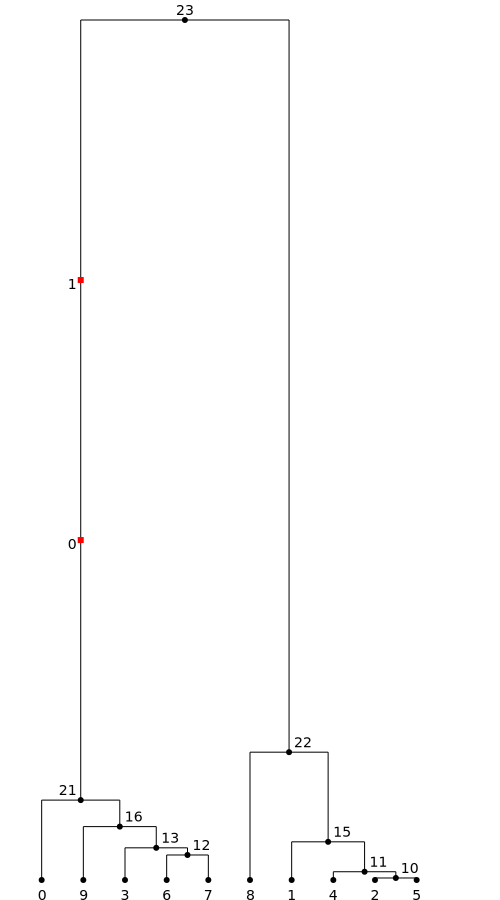

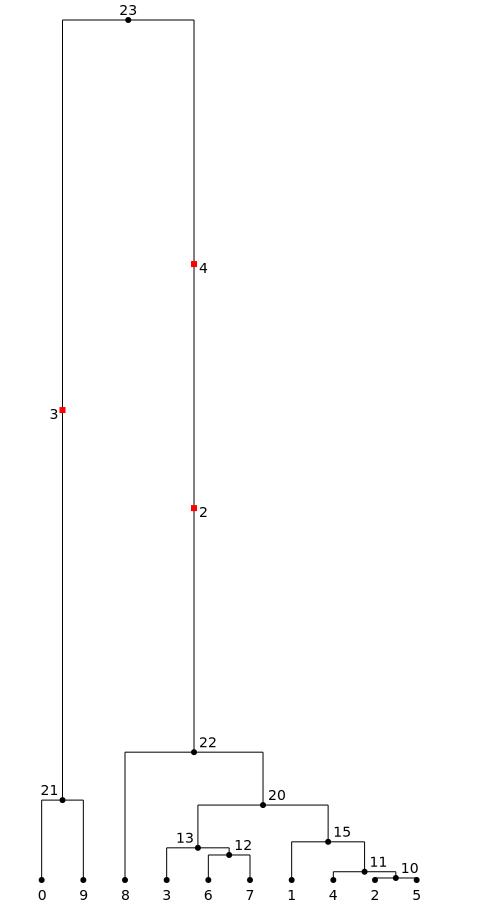

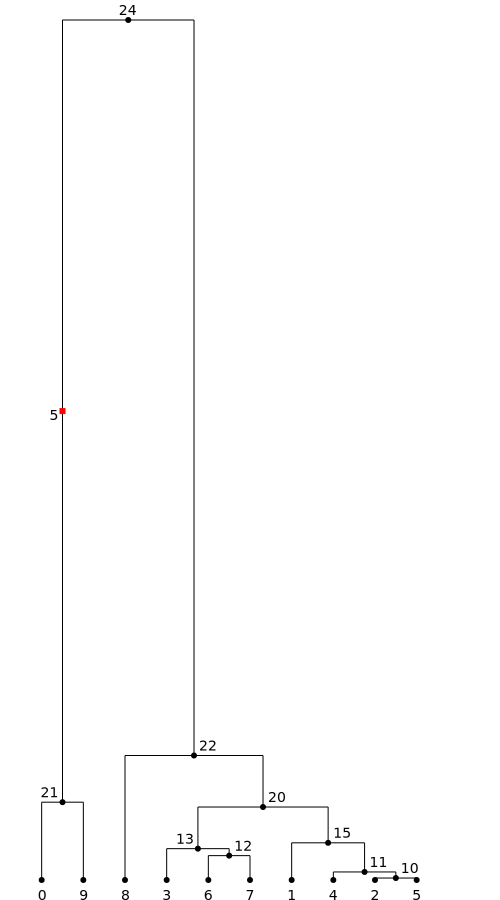

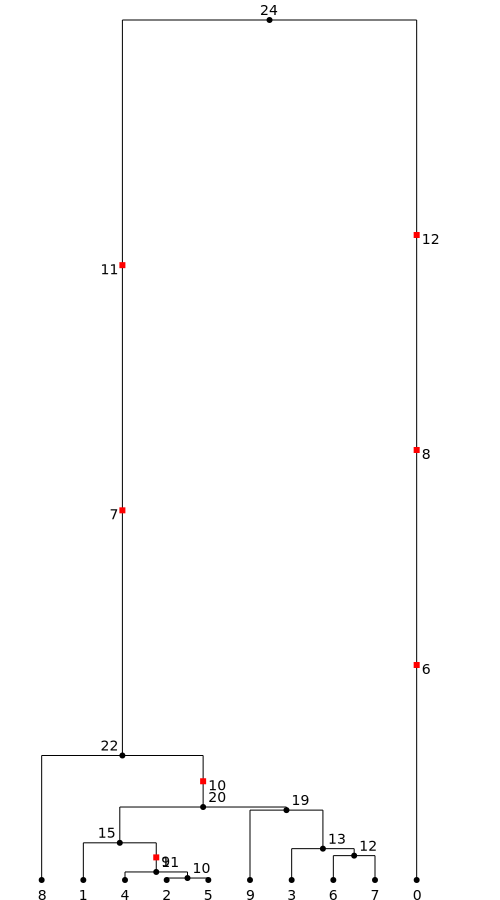

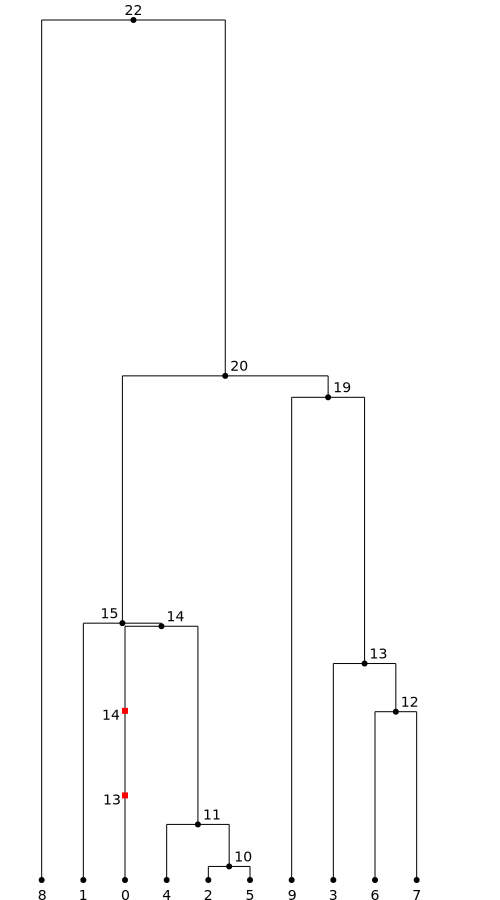

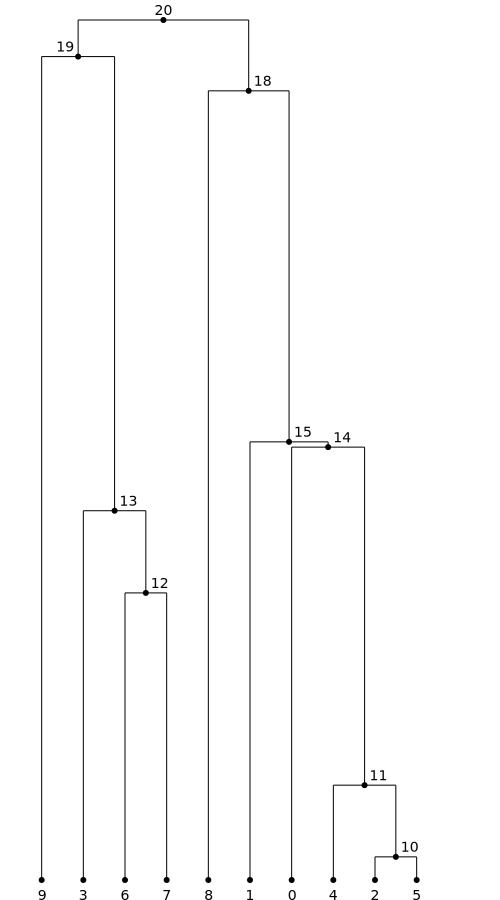

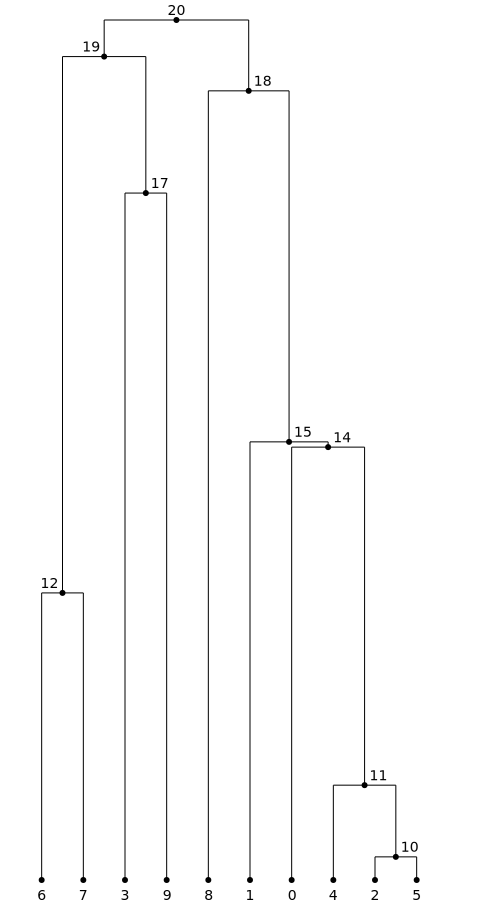

In [692]:
for tree in simulated_ts.trees():
    display(SVG(tree.draw(height=900,width=500)))